##### Copyright 2018 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=ByZjmtFgB_Y5).

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/swift/tutorials/python_interoperability"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/swift/blob/master/docs/site/tutorials/python_interoperability.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/swift/blob/master/docs/site/tutorials/python_interoperability.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Python interoperability

Swift For TensorFlow supports Python interoperability.

You can import Python modules from Swift, call Python functions, and convert values between Swift and Python.

In [5]:
import Python
print(Python.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


## Setting the Python version

By default, when you `import Python`, Swift searches system library paths for the newest version of Python installed. 
To use a specific Python installation, set the `PYTHON_LIBRARY` environment variable to the `libpython` shared library provided by the installation.  For example: 

`export PYTHON_LIBRARY="~/anaconda3/lib/libpython3.7m.so"`

The exact filename will differ across Python environments and platforms.

Alternatively, you can set the `PYTHON_VERSION` environment variable, which instructs Swift to search system library paths for a matching Python version. Note that `PYTHON_LIBRARY` takes precedence over `PYTHON_VERSION`.

In code, you can also call the `PythonLibrary.useVersion` function, which is equivalent to setting `PYTHON_VERSION`.

In [8]:
// PythonLibrary.useVersion(2)
// PythonLibrary.useVersion(3, 7)

__Note: you should run `PythonLibrary.useVersion` right after `import Python`, before calling any Python code. It cannot be used to dynamically switch Python versions.__

Set `PYTHON_LOADER_LOGGING=1` to see [debug output for Python library loading](https://github.com/apple/swift/pull/20674#discussion_r235207008).  

## Basics

In Swift, `PythonObject` represents an object from Python.
All Python APIs use and return `PythonObject` instances.

Basic types in Swift (like numbers and arrays) are convertible to `PythonObject`. In some cases (for literals and functions taking `PythonConvertible` arguments), conversion happens implicitly. To explicitly cast a Swift value to `PythonObject`, use the `PythonObject` initializer.

`PythonObject` defines many standard operations, including numeric operations, indexing, and iteration.

In [0]:
// Convert standard Swift types to Python.
let pythonInt: PythonObject = 1
let pythonFloat: PythonObject = 3.0
let pythonString: PythonObject = "Hello Python!"
let pythonRange: PythonObject = PythonObject(5..<10)
let pythonArray: PythonObject = [1, 2, 3, 4]
let pythonDict: PythonObject = ["foo": [0], "bar": [1, 2, 3]]

// Perform standard operations on Python objects.
print(pythonInt + pythonFloat)
print(pythonString[0..<6])
print(pythonRange)
print(pythonArray[2])
print(pythonDict["bar"])

4.0
Hello 
slice(5, 10, None)
3
[1, 2, 3]


In [0]:
// Convert Python objects back to Swift.
let int = Int(pythonInt)!
let float = Float(pythonFloat)!
let string = String(pythonString)!
let range = Range<Int>(pythonRange)!
let array: [Int] = Array(pythonArray)!
let dict: [String: [Int]] = Dictionary(pythonDict)!

// Perform standard operations.
// Outputs are the same as Python!
print(Float(int) + float)
print(string.prefix(6))
print(range)
print(array[2])
print(dict["bar"]!)

4.0
Hello 
5..<10
3
[1, 2, 3]


`PythonObject` defines conformances to many standard Swift protocols:
* `Equatable`
* `Comparable`
* `Hashable`
* `SignedNumeric`
* `Strideable`
* `MutableCollection`
* All of the `ExpressibleBy_Literal` protocols

Note that these conformances are not type-safe: crashes will occur if you attempt to use protocol functionality from an incompatible `PythonObject` instance.

In [0]:
let one: PythonObject = 1
print(one == one)
print(one < one)
print(one + one)

let array: PythonObject = [1, 2, 3]
for (i, x) in array.enumerated() {
    print(i, x)
}

true
false
2
0 1
1 2
2 3


To convert tuples from Python to Swift, you must statically know the arity of the tuple.

Call one of the following instance methods:
- `PythonObject.tuple2`
- `PythonObject.tuple3`
- `PythonObject.tuple4`

In [0]:
let pythonTuple = Python.tuple([1, 2, 3])
print(pythonTuple, Python.len(pythonTuple))

// Convert to Swift.
let tuple = pythonTuple.tuple3
print(tuple)

(1, 2, 3) 3
(1, 2, 3)


## Python builtins

Access Python builtins via the global `Python` interface.

In [0]:
// `Python.builtins` is a dictionary of all Python builtins.
_ = Python.builtins

// Try some Python builtins.
print(Python.type(1))
print(Python.len([1, 2, 3]))
print(Python.sum([1, 2, 3]))

<class 'int'>
3
6


## Importing Python modules

Use `Python.import` to import a Python module. It works like the `import` keyword in `Python`.

In [0]:
let np = Python.import("numpy")
print(np)
let zeros = np.ones([2, 3])
print(zeros)

<module 'numpy' from '/usr/local/lib/python3.6/dist-packages/numpy/__init__.py'>
[[1. 1. 1.]
 [1. 1. 1.]]


Use the throwing function `Python.attemptImport` to perform safe importing.

In [0]:
let maybeModule = try? Python.attemptImport("nonexistent_module")
print(maybeModule)

nil


## Conversion with `numpy.ndarray`

The following Swift types can be converted to and from `numpy.ndarray`:
- `Array<Element>`
- `ShapedArray<Scalar>`
- `Tensor<Scalar>`

Conversion succeeds only if the `dtype` of the `numpy.ndarray` is compatible with the `Element` or `Scalar` generic parameter type.

For `Array`, conversion from `numpy` succeeds only if the `numpy.ndarray` is 1-D.

In [0]:
import TensorFlow

let numpyArray = np.ones([4], dtype: np.float32)
print("Swift type:", type(of: numpyArray))
print("Python type:", Python.type(numpyArray))
print(numpyArray.shape)

Swift type: PythonObject
Python type: <class 'numpy.ndarray'>
(4,)


In [0]:
// Examples of converting `numpy.ndarray` to Swift types.
let array: [Float] = Array(numpy: numpyArray)!
let shapedArray = ShapedArray<Float>(numpy: numpyArray)!
let tensor = Tensor<Float>(numpy: numpyArray)!

// Examples of converting Swift types to `numpy.ndarray`.
print(array.makeNumpyArray())
print(shapedArray.makeNumpyArray())
print(tensor.makeNumpyArray())

// Examples with different dtypes.
let doubleArray: [Double] = Array(numpy: np.ones([3], dtype: np.float))!
let intTensor = Tensor<Int32>(numpy: np.ones([2, 3], dtype: np.int32))!

[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]


## Displaying images

You can display images in-line using `matplotlib`, just like in Python notebooks.

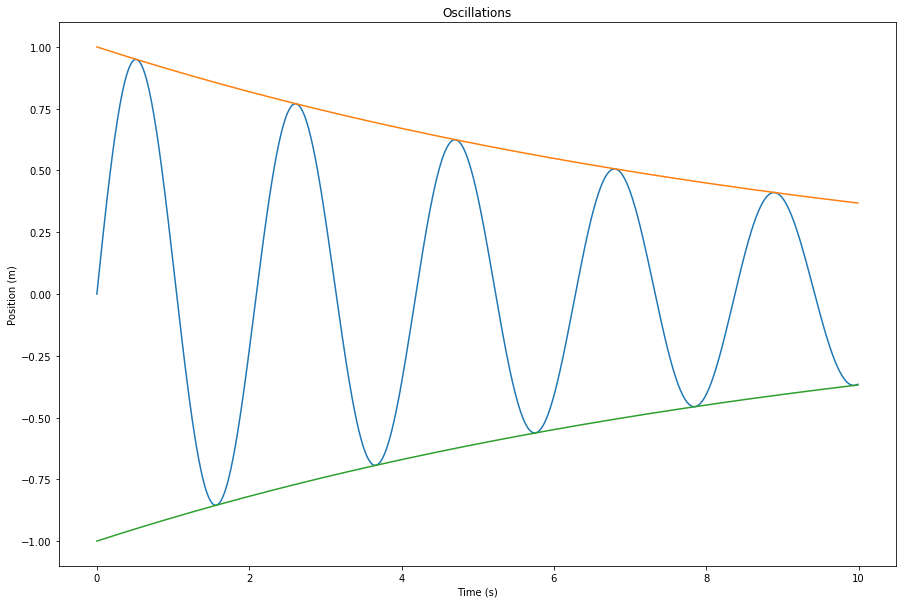

None


In [0]:
// Setup.
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

let time = np.arange(0, 10, 0.01)
let amplitude = np.exp(-0.1 * time)
let position = amplitude * np.sin(3 * time)

plt.figure(figsize: [15, 10])

plt.plot(time, position)
plt.plot(time, amplitude)
plt.plot(time, -amplitude)

plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Oscillations")

plt.show()